<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Context" data-toc-modified-id="Context-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Context</a></span></li><li><span><a href="#Model-choice" data-toc-modified-id="Model-choice-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model choice</a></span></li><li><span><a href="#Parameter-estimation" data-toc-modified-id="Parameter-estimation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Parameter estimation</a></span></li></ul></div>

# Context

We have several evolutionary models with divergence and/or admixtures events. The time of events and the admixture rate (respective proportions of genes from admixed populations).

We compare six evolutionary scenarios and we simulate observed data for the scenario n°3 with the following parameters:
$N1=7,000$, $N2=2,000$, $N3=4,000$, $N4=3000$, $t1=200$, $ra=0.3$, $t2=300$ and $t3=500$

<center>
    <img src="scenarios.png"/>
<center/>

# Model choice
ABC simulations of six scenarios are made (12k samples).

In [1]:
import h5py
import sys
sys.path.insert(0,'../build')
import pyabcranger

import numpy as np

In [2]:
f = h5py.File('modelchoice-reftable.h5','r')
statobs = np.loadtxt('modelchoice-statobs.txt',skiprows=2)

In [3]:
stats = np.transpose(f['stats'])
params = np.transpose(f['params'])

rf = pyabcranger.reftable(
    f['nrec'][0],
    f['nrecscen'],
    f['nparam'],
    f['params'].attrs['params_names'],
    f['stats'].attrs['stats_names'],
    stats,
    params,
    f['scenarios']
    )

In [4]:
ntree = 500

postres = pyabcranger.modelchoice(rf, statobs,"--ntree "+str(ntree),False)
print('Predicted model  : ', postres.predicted_model + 1)
print('votes : ', postres.votes)
print('Posterior probability : ', postres.post_proba)

///////////////////////////////////////// First forest (training on ABC output)
Growing trees ..
  ████████████████████████████████████████▏ 100.0% [ 500/ 500 | 134.4 Hz | 4s<0s]  
Computing prediction error ..
///////////////////////////////////////// Second forest (training on error)
Growing trees ..
  ████████████████████████████████████████▏ 100.0% [ 500/ 500 | 549.8 Hz | 1s<0s]  
Computing prediction error ..
 votes model1 votes model2 votes model3 votes model4 votes model5 votes model6 selected model post proba
            5           61          397            4           26            7              3      0.726
Predicted model  :  3
votes :  [5, 61, 397, 4, 26, 7]
Posterior probability :  0.7262666666666666


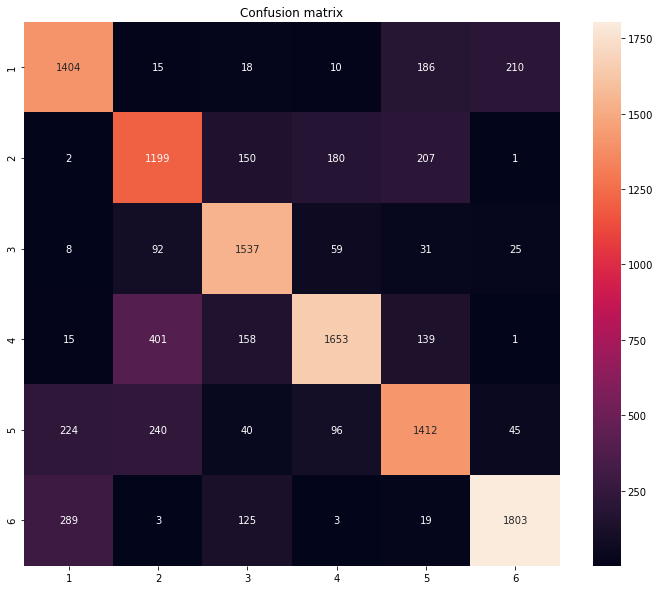

In [5]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
df_cm = pd.DataFrame(postres.confusion_matrix,range(1,7),range(1,7))
sn.heatmap(df_cm, annot=True,annot_kws={"size": 10},fmt='d')
plt.title('Confusion matrix');

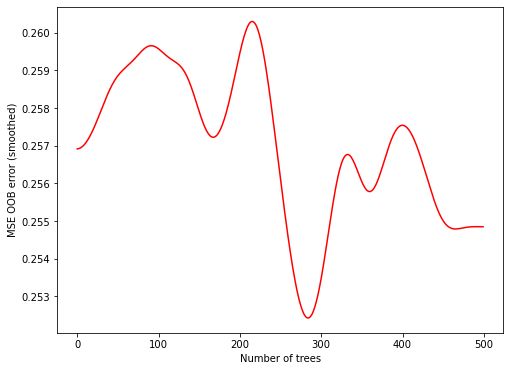

In [6]:
from scipy.ndimage.filters import gaussian_filter1d
ntree_oob_error_smoothed = gaussian_filter1d(postres.ntree_oob_error, sigma=20.0)
plt.figure(figsize=(8,6))
#plt.scatter(range(ntree),postres.ntree_oob_error,color='b',marker='.')
plt.plot(ntree_oob_error_smoothed,'r')
#plt.yscale('log')
plt.xlabel('Number of trees')
plt.ylabel('MSE OOB error (smoothed)');

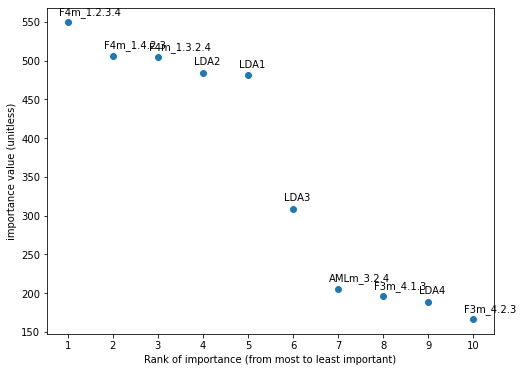

In [7]:
l  = len(postres.variable_importance)
ntop = min(10,l)
#lr = range(l-1,-1,-1)
lr = range(ntop)
labels = [postres.variable_importance[i][0] for i in lr]
imp    = [postres.variable_importance[i][1] for i in lr]
plt.figure(figsize=(8, 6))
plt.scatter(range(1,ntop+1),imp)
plt.xticks(range(1,ntop+1))
for i in range(ntop):
    plt.text(i+0.8,imp[i]+10,labels[i])
plt.xlabel('Rank of importance (from most to least important)')
plt.ylabel('importance value (unitless)')
plt.show() 

# Parameter estimation

As we already chose scenario n°3, we generate ABC samples (12k) for analysis and parameter estimation.

In [8]:
f = h5py.File('estimparam-reftable.h5','r')
statobs = np.loadtxt('estimparam-statobs.txt',skiprows=2)

In [9]:
stats = np.transpose(f['stats'])
params = np.transpose(f['params'])

rf = pyabcranger.reftable(
    f['nrec'][0],
    f['nrecscen'],
    f['nparam'],
    f['params'].attrs['params_names'],
    f['stats'].attrs['stats_names'],
    stats,
    params,
    f['scenarios']
    )

In [10]:
postres = pyabcranger.estimparam(rf,statobs,"--ntree 500 --parameter ra --noob 2000 --chosenscen 1",False, False)

Selecting only 9 pls components.
Growing trees ..
  ████████████████████████████████████████▏ 100.0% [ 500/ 500 | 128.6 Hz | 4s<0s]  
Computing prediction error ..

Parameter estimation (point estimates)
   Expectation        Median Quantile_0.05 Quantile_0.95      Variance
      0.402551      0.392571      0.271449      0.613605      0.007742

Global (prior) errors
Computed from the mean taken as point estimate
                     NMAE : 0.17132747841881507
                      MSE : 0.006508670049578047
                     NMSE : 0.021139407210307576
Computed from the median taken as point estimate
                     NMAE : 0.14653579722455093
                      MSE : 0.006296822829806595
                     NMSE : 0.01671209260271997
Confidence interval measures
             90% coverage : 0.9655       
              Mean 90% CI : 0.28045824487817755
     Mean relative 90% CI : 0.8388748698926642
            Median 90% CI : 0.23365875929594038
   Median relative 90% CI : 0.

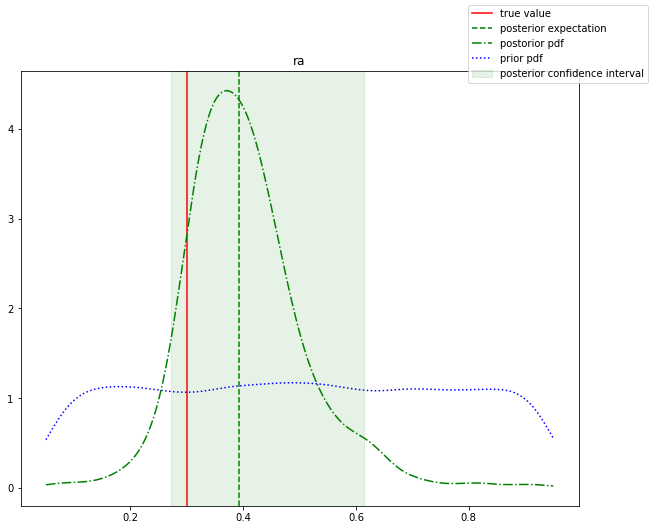

In [11]:
from scipy.stats import gaussian_kde
ra_reality = 0.3
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
x,y = np.asanyarray(postres.values_weights)[:,0],np.asanyarray(postres.values_weights)[:,1]
pdfw = gaussian_kde(x,weights=y)
pdf = gaussian_kde(x)
xp = np.linspace(np.min(x), np.max(x), 200)
ax.set_title('ra')
ax.axvline(x=ra_reality, color='r')
ax.axvline(postres.point_estimates['Median'], color='g', linestyle = '--')
ax.axvspan(postres.point_estimates['Quantile_0.05'],
           postres.point_estimates['Quantile_0.95'],
           alpha=0.1,color='g')
ax.plot(xp,pdfw(xp),color="g",linestyle = '-.')
ax.plot(xp,pdf(xp),color="b", linestyle = 'dotted')

fig.legend(['true value',
            'posterior expectation',
            'postorior pdf','prior pdf',
            'posterior confidence interval']);
